# Sort spikes and make bout/motif rasters
For every run in the session:
 - Load the recordings
 - Get the sync events for the nidq, ap, lf sync channels -> to npy for further synching 
 - Sort spikes
 - Get the bouts/mots and align them to the ap_0 time scale
 - make and view some 'bout rasters'
 

Assumes that preprocessing has occured:
- sglx_preprocess:
    - extraction of microphone streams
    - bout detections
- curate_bouts-bird-plotly-ephys:
    - manual curation of detected bouts

In [2]:
%matplotlib inline

import os
import glob
import logging
import pickle
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy import signal

from matplotlib import pyplot as plt
from importlib import reload

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)


os.environ["KILOSORT2_PATH"] = '/mnt/cube/earneodo/repos/Kilosort2'
os.environ["KILOSORT3_PATH"] = '/home/finch/repos/Kilosort'
os.environ["NPY_MATLAB_PATH"] = '/mnt/cube/earneodo/repos/npy-matlab'

In [3]:
import pickle

In [4]:
from ceciestunepipe.file import bcistructure as et
from ceciestunepipe.util import sglxutil as sglu
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import readSGLX as rsgl
from ceciestunepipe.util.spikeextractors.extractors.spikeglxrecordingextractor import spikeglxrecordingextractor as sglex

h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


In [5]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
logger.info('all modules loaded')

2021-10-06 22:53:13,529 root         INFO     all modules loaded


In [53]:
si.__version__

'0.12.0'

In [55]:
se.__version__

'0.9.3'

### Session parameters and raw files

In [6]:
reload(et)

bird = 's_b1253_21'
all_bird_sess = et.list_sessions(bird)
#all_bird_sess

In [7]:
reload(et)
sess_par = {'bird': 's_b1253_21',
           'sess': '2021-07-18',
           'probe': 'probe_0',
           'sort': 2}

exp_struct = et.get_exp_struct(sess_par['bird'], sess_par['sess'], sort=sess_par['sort'])

ksort_folder = exp_struct['folders']['ksort']
raw_folder = exp_struct['folders']['sglx']

In [8]:
raw_folder

'/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx'

In [9]:
sess_epochs = et.list_sgl_epochs(sess_par)
sess_epochs

2021-10-06 22:53:14,611 ceciestunepipe.file.bcistructure INFO     {'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21', 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18', 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18', 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx', 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx', 'tmp': '/experiment/tmp/tmp', 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-07-18', 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18'}, 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/params.json', 'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/settings.isf', 'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/rig.json', 'kwd': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/stream.kwd', 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/sort_2/s

['0610_g0', '1423_g0', '1615_g0']

In [10]:
### pick a session, epoch
reload(et)
reload(sglu)
epoch = sess_epochs[0] # g2 is the shortest
sess_par['epoch'] = epoch

exp_struct = et.sgl_struct(sess_par, epoch)
sgl_folders, sgl_files = sglu.sgl_file_struct(exp_struct['folders']['sglx'])

In [11]:
exp_struct

{'folders': {'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0610_g0',
  'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/0610_g0',
  'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0',
  'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/0610_g0',
  'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx/0610_g0',
  'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0',
  'tmp': '/experiment/tmp/tmp/0610_g0',
  'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-07-18/0610_g0',
  'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0'},
 'files': {'par': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/params.json',
  'set': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/settings.isf',
  'rig': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/rig.json',
  'kwd': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/0610_g0/stream.kwd',
  'kwik': '/expe

In [12]:
sgl_folders

{'nidq': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'imec_0': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0/0610_g0_imec0'}

In [13]:
sgl_files

{'nidq': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0/0610_g0_t0.nidq.meta'],
 'lf_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0/0610_g0_imec0/0610_g0_t0.imec0.lf.meta'],
 'ap_0': ['/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0/0610_g0_imec0/0610_g0_t0.imec0.ap.meta']}

In [14]:
files_pd = pd.DataFrame(sgl_files)

In [15]:
files_pd

,nidq,lf_0,ap_0
0,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...,/mnt/sphere/speech_bci/raw_data/s_b1253_21/202...


### load epoch files

In [16]:
probe_id = int(sess_par['probe'].split('_')[-1])
i_run = 0

run_meta_files = {k: v[i_run] for k, v in sgl_files.items()}
run_recordings = {k: sglex.SpikeGLXRecordingExtractor(sglu.get_data_meta_path(v)[0]) for k, v in run_meta_files.items()}

mic_file_name = os.path.join(exp_struct['folders']['derived'], 'wav_mic.wav')
#probe_data_folder = sgl_folder['imec'][probe_id]


### do the sync
- get the sync events from the recordings 
- write the npy sync event files

In [17]:
stream = 'lf_0'
syn_tuples_dict = {}

# skipping this: see get_syn_pattern function
#syn_tuples_dict[stream] = run_recordings[stream].get_effective_sf()

In [18]:
def load_syn_dict(exp_struct: dict, stream:str, arrays_to_load=['evt_arr', 't_0']) -> dict:
    
    syn_dict_path = os.path.join(exp_struct['folders']['derived'],  
                                 '{}_sync_dict.pkl'.format(stream))
    logger.info('loading syn_dict from ' + syn_dict_path)
    with open(syn_dict_path, 'rb') as f:
        syn_dict = pickle.load(f)
     
    for arr in arrays_to_load:
        arr_path = syn_dict['{}_path'.format(arr)]
        syn_dict[arr] = np.load(arr_path, mmap_mode='r')
    return syn_dict

def get_syn_pattern(run_recs_dict, exp_struct, stream:str, force=False):
    logger.info('getting syn patterns for {}'.format(stream))
    syn_dict_path = os.path.join(exp_struct['folders']['derived'], '{}_sync_dict.pkl'.format(stream))
    
    # if Force=true of file not found, compute it from the recording_dict
    if not(os.path.exists(syn_dict_path) and (force is False)):
        logger.info('File {} not found or forced computation, getting the events'.format(syn_dict_path))
        syn_tuple = run_recs_dict[stream].get_effective_sf()
        syn_arr = np.vstack(list(syn_tuple[2][:]))
        
        t_0_path = os.path.join(exp_struct['folders']['derived'],  '{}_t0.npy'.format(stream))
        syn_npy_path = os.path.join(exp_struct['folders']['derived'],  '{}_sync_evt.npy'.format(stream))
                                 
        logger.info('saving events array to ' + syn_npy_path)
        np.save(syn_npy_path, syn_arr)
        
        logger.info('saving t_0 array to ' + t_0_path)                                 
        np.save(t_0_path, syn_tuple[1])
        
        syn_dict = {'path': syn_dict_path,
                    's_f': syn_tuple[0],
                   't_0_path': t_0_path,
                    'evt_arr_path': syn_npy_path
                   }
        
        # save without the array, and open the array as a memmap
        logger.info('saving sync dict to ' + syn_dict_path)
        with open(syn_dict_path, 'wb') as pf:
            pickle.dump(syn_dict, pf)
    
#     else:
#         syn_dict = load_syn_dict(exp_struct, stream, arrays_to_load=[])
#         syn_dict['path'] = syn_dict_path
#         # save without the array, and open the array as a memmap
#         logger.info('saving sync dict to ' + syn_dict_path)
#         with open(syn_dict_path, 'wb') as pf:
#             pickle.dump(syn_dict, pf)
            
    ## in any case, load the saved dict so everything comes from the memmaped arrays
    syn_dict = load_syn_dict(exp_struct, stream) 
        
    return syn_dict

get_syn_pattern(run_recordings, exp_struct, 'wav', force=False)

2021-10-06 22:53:27,509 root         INFO     getting syn patterns for wav
2021-10-06 22:53:27,527 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_sync_dict.pkl


{'s_f': 25000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_sync_evt.npy',
 'path': 'path',
 'evt_arr': memmap([[     2321,     14687,     27321, ..., 738242072, 738254438,
          738267073],
         [        1,        -1,         1, ...,         1,        -1,
                  1]]),
 't_0': memmap([0.00000000e+00, 4.00000000e-05, 8.00000000e-05, ...,
         2.95308717e+04, 2.95308717e+04, 2.95308718e+04])}

In [19]:
#get_syn_pattern(run_recordings, exp_struct, 'wav')

##### get the syn patterns for all of the signals

In [20]:
# all the streams are the ones in the recording_extractors from the raw data, plus the ones generated in sglx_preprocess
all_streams = list(run_recordings.keys()) + ['wav']

#all_streams = ['lf_0', 'ap_0', 'nidq']
#all_streams = ['ap_0', 'wav']
all_syn_dict = {k: get_syn_pattern(run_recordings, exp_struct, k, force=False) for k in all_streams[:]}

2021-10-06 22:53:29,510 root         INFO     getting syn patterns for nidq
2021-10-06 22:53:29,513 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/nidq_sync_dict.pkl
2021-10-06 22:54:33,081 root         INFO     getting syn patterns for lf_0
2021-10-06 22:54:33,109 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/lf_0_sync_dict.pkl
2021-10-06 22:54:38,516 root         INFO     getting syn patterns for ap_0
2021-10-06 22:54:38,518 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/ap_0_sync_dict.pkl
2021-10-06 22:54:38,626 root         INFO     getting syn patterns for wav
2021-10-06 22:54:38,627 root         INFO     loading syn_dict from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_sync_dict.pkl


In [21]:
all_syn_dict['wav']

{'s_f': 25000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_sync_evt.npy',
 'path': 'path',
 'evt_arr': memmap([[     2321,     14687,     27321, ..., 738242072, 738254438,
          738267073],
         [        1,        -1,         1, ...,         1,        -1,
                  1]]),
 't_0': memmap([0.00000000e+00, 4.00000000e-05, 8.00000000e-05, ...,
         2.95308717e+04, 2.95308717e+04, 2.95308718e+04])}

#### do the synchronization usin the syn dict

In [22]:
from scipy.interpolate import interp1d

In [23]:
def sync_to_pattern(x_ttl: np.array, t: np.array, x_0_ttl: np.array, t_0:np.array) -> np.array:
    # x_ttl is the array of [2, n_transition] ([transition_sign, sample] (transition = +/-1))
    # strategy is
    # check:
        # first edges are both same sign 
        # number of edges is the same
    # get times to interpolate:
    # get the 'actual' times at the edges, i.e the t_0 at the locationn of the edges in x_0, regardless of the sign (two values per cycle, means T/2 is the actual period)
    # make an interpolation function with it
    # fit the t to those values (we know that t=t_0 at those edges, the rest is the correciton of the interpolation)
    n_edges = x_ttl.shape[1]
    n_edges_0 = x_0_ttl.shape[1]
    if x_ttl[1, 0] != x_0_ttl[1, 0]:
        # If the signals don't have the same number of edges there may be an error, better stop and debug
        raise ValueError(
            'Sign of first edge transition of pattern and target dont match')
    if n_edges != n_edges_0:
        # If the signals don't have the same number of edges there may be an error, better stop and debug
        raise ValueError(
            'Number of edges in the syn ttl events of pattern and target dont match')
        
    # if all checks out, do the deed
    t_0_edge = t_0[x_0_ttl[0]]
    sample_edge = x_ttl[0]
    # the interpolation function. fill_value='extrapolate' allows extrapolation from zero and until the last time stamp
    # careful, this could lead to negative time, but it is the correct way to do it.
    # interpolation function interpolates time as a target, t_0=f(sample) with true values at the edges
    t_interp_f = interp1d(sample_edge, t_0_edge,
                          assume_sorted=True, 
                          fill_value='extrapolate')
    
    n_samples = t.size
    t_prime = t_interp_f(np.arange(n_samples))
    return t_prime

# t_p_lf = sync_to_pattern(all_syn_dict['wav']['evt_arr'], all_syn_dict['wav']['t_0'], 
#                         all_syn_dict['ap_0']['evt_arr'], all_syn_dict['ap_0']['t_0'])    

### quickly test this sync

### get all of the streams syncched to a reference_stream

In [24]:
ref_stream = 'ap_0'

def sync_all(all_syn_dict: dict, ref_stream: str, force=False) -> dict:
    logger.info('syncing all times to {}'.format(ref_stream))
    ref_syn_dict = all_syn_dict[ref_stream]
    for one_stream, one_syn_dict in all_syn_dict.items():
        if one_stream==ref_stream:
            continue
            
        logger.info(' synch {}...'.format(one_stream))
        
        t_0_folder = os.path.split(one_syn_dict['t_0_path'])[0]
        t_p_path = os.path.join(t_0_folder, '{}-tp.npy'.format(one_stream))
        
        if not(os.path.exists(t_p_path) and (force is False)):
            logger.info('  t_prime file {} not found or forced computation, getting the events'.format(t_p_path))
        
            t_prime = sync_to_pattern(one_syn_dict['evt_arr'], one_syn_dict['t_0'],
                                                     ref_syn_dict['evt_arr'], ref_syn_dict['t_0'])
            logger.info('    saving t_prime array to ' + t_p_path)                                 
            np.save(t_p_path, t_prime)
        
            #clar the memory, then load as memmap
            del t_prime
        
            one_syn_dict['t_p_path'] = t_p_path
            # save the dict with the path to the sync it
            logger.info('    saving synced dict to {}'.format(one_syn_dict['path']))
            with open(one_syn_dict['path'], 'wb') as fp:
                pickle.dump(one_syn_dict, fp)
            
        one_syn_dict['t_p'] = np.load(t_p_path, mmap_mode='r')
    return

sync_all(all_syn_dict, 'ap_0', force=False)

2021-10-06 22:54:39,014 root         INFO     syncing all times to ap_0
2021-10-06 22:54:39,015 root         INFO      synch nidq...
2021-10-06 22:54:39,093 root         INFO      synch lf_0...
2021-10-06 22:54:39,146 root         INFO      synch wav...


In [25]:
all_syn_dict['wav']

{'s_f': 25000,
 't_0_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_t0.npy',
 'evt_arr_path': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/wav_sync_evt.npy',
 'path': 'path',
 'evt_arr': memmap([[     2321,     14687,     27321, ..., 738242072, 738254438,
          738267073],
         [        1,        -1,         1, ...,         1,        -1,
                  1]]),
 't_0': memmap([0.00000000e+00, 4.00000000e-05, 8.00000000e-05, ...,
         2.95308717e+04, 2.95308717e+04, 2.95308718e+04]),
 't_p': memmap([-1.01895101e-03, -9.78514932e-04, -9.38078849e-04, ...,
          2.95312796e+04,  2.95312796e+04,  2.95312796e+04])}

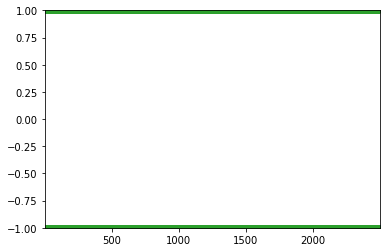

In [26]:
n_periods = 5000

# L_f against t prime
t_p_lf = all_syn_dict['lf_0']['t_p']
t_primes = t_p_lf[all_syn_dict['lf_0']['evt_arr'][0,:n_periods]]
t_naive = all_syn_dict['lf_0']['t_0'][all_syn_dict['lf_0']['evt_arr'][0,:n_periods]]
edges = all_syn_dict['lf_0']['evt_arr'][1, :n_periods]

t_0 = all_syn_dict['ap_0']['t_0'][all_syn_dict['ap_0']['evt_arr'][0,:n_periods]]
edges_0 = all_syn_dict['ap_0']['evt_arr'][1, :n_periods]

plt.plot(t_primes, edges, '*')

plt.plot(t_0, edges_0, '.')

plt.plot(t_naive, edges, '+')

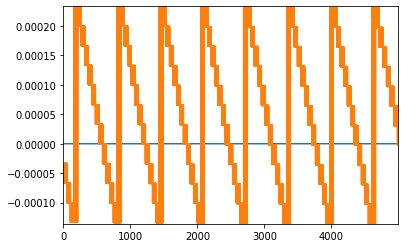

In [27]:
plt.plot(t_primes - t_0)
plt.plot(t_naive - t_0)

## Get the bouts
- read the curated bouts file (or a list) for the epoch
- get starts:ends in t_naive of the wav file
- get the corresponding tprimes to refer to the spikes

#### plot a sample bout

In [28]:
## I see in the wav there is a bout starting in 354.64 (5 motifs) this was for 2021-06-14 morning epoch
## also in 13871.53 (6 motifs)
# hand_bouts_s_list = [[15.67, 52.68], [64.84, 94.58], [111.02, 146.63], [179.46, 216.49], [283.67, 313.12],
#                     [369.58, 397.95], [412.45, 445.62], [463.16, 492.1], [1327.1, 1361.1], [1375.9, 1408.62],
#                      [1422.92, 1457], [1476.9, 1501.1], [1512.13, 1539.34], [1585.77, 1611.63], [1625.0, 1650.79], 
#                      [1909.14, 1949.73], [1970.4, 2004.9], [2019.31, 2056.6], [2653.6, 2685.6], [2767.5, 2816.42],
#                     [3010.18, 3042.15], [3130.47, 3181.86], [3213.9, 3244.54], [3274.5, 3305.18], [3331, 3364],
#                     [3383.83, 3413.7], [3447.1, 3476.3], [3849.7, 3877.12], [3878.39, 3898.9], [3919.67, 3951.7],
#                     [3973.89, 4005.8], [4028.38, 4063.42], [4136, 4180.2], [4227.18, 4269.95], [4321.5, 4363.22], 
#                      [4993.97, 5037.25], [5110.29, 5155.6], [5263.8, 5295], [5439.42, 5473.1], [5560.35, 5592.9],
#                      [6410.95, 6451.9], [6718.5, 6752.87], [6771.67, 6802.21], [16330.8, 16362.41], [16385.5, 16425.23],
#                      [17007.44, 17041.41], [17237, 17278.45], [17388.3, 17442.17]]

# hand_bouts_arr = np.array(hand_bouts_s_list)
# hand_bouts_arr.shape

In [29]:
def bout_dict_from_array(bout_arr: np.array, all_syn_dict: dict) -> dict:
    s_f_wav = all_syn_dict['wav']['s_f']
    
    start_ms = (bout_arr[:, 0]*1000).astype(np.int64)
    len_ms = (np.diff(bout_arr)*1000).astype(np.int64).flatten()
    
    
    bout_dict = {
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': all_syn_dict['nidq']['s_f'],
            's_f_ap_0': all_syn_dict['ap_0']['s_f'],
           'start_ms': start_ms,
            'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int64),
           'start_sample_nidq': np.array([np.where(all_syn_dict['nidq']['t_0'] > start)[0][0] for start in start_ms*0.001]),
            'start_sample_wav': np.array([np.where(all_syn_dict['wav']['t_0'] > start)[0][0] for start in start_ms*0.001])
           }
    
    start_ms_ap_0 = all_syn_dict['wav']['t_p'][bout_dict['start_sample_wav']]*1000
    
    bout_dict['start_ms_ap_0'] = start_ms_ap_0
    bout_dict['start_sample_ap_0'] = np.array([np.where(all_syn_dict['ap_0']['t_0'] > start)[0][0] for start in start_ms_ap_0*0.001])
    bout_dict['start_sample_ap_0'] = (bout_dict['start_sample_ap_0']).astype(np.int64)
    return bout_dict

#bout_dict = bout_dict_from_array(hand_bouts_arr, all_syn_dict)

In [30]:
def bout_dict_from_pd(bout_pd: pd.DataFrame, all_syn_dict: dict) -> dict:
    s_f_wav = all_syn_dict['wav']['s_f']
    
    start_ms = bout_pd['start_ms'].values
    len_ms = bout_pd['len_ms'].values
    
    bout_dict = {
            's_f': s_f_wav, # s_f used to get the spectrogram
            's_f_nidq': all_syn_dict['nidq']['s_f'],
            's_f_ap_0': all_syn_dict['ap_0']['s_f'],
           'start_ms': start_ms,
            'len_ms': len_ms,
           'start_sample_naive': ( start_ms * s_f_wav * 0.001).astype(np.int64),
           'start_sample_nidq': np.array([np.where(all_syn_dict['nidq']['t_0'] > start)[0][0] for start in start_ms*0.001]),
            'start_sample_wav': np.array([np.where(all_syn_dict['wav']['t_0'] > start)[0][0] for start in start_ms*0.001])
           }
    
    start_ms_ap_0 = all_syn_dict['wav']['t_p'][bout_dict['start_sample_wav']]*1000
    
    bout_dict['start_ms_ap_0'] = start_ms_ap_0
    bout_dict['start_sample_ap_0'] = np.array([np.where(all_syn_dict['ap_0']['t_0'] > start)[0][0] for start in start_ms_ap_0*0.001])
    bout_dict['start_sample_ap_0'] = (bout_dict['start_sample_ap_0']).astype(np.int64)
    return bout_dict

reload(et)
##### the bouts pandas file filtered for this session
bout_pd = et.get_epoch_bout_pd(sess_par, only_curated=True)
bout_dict = bout_dict_from_pd(bout_pd, all_syn_dict)

2021-10-06 22:54:53,675 ceciestunepipe.file.bcistructure INFO     loading curated bouts for session 2021-07-18 from /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/bouts_sglx/bout_curated.pickle
2021-10-06 22:55:36,576 ceciestunepipe.file.bcistructure INFO     Filtering bouts for epoch 0610_g0
2021-10-06 22:55:36,756 ceciestunepipe.file.bcistructure INFO     Filtering also only manually curated bouts


In [31]:
sess_par

{'bird': 's_b1253_21',
 'sess': '2021-07-18',
 'probe': 'probe_0',
 'sort': 2,
 'epoch': '0610_g0'}

In [32]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.652952032644,
 's_f_ap_0': 30000.043852965577,
 'start_ms': array([ 6300478,  7102501,  7180616,  7245376,  7661606,  8031581,
         8128521,  8202321,  8442876,  9853004, 11014954, 12578659,
        14212972, 15410472, 15496242, 17104694, 18395779, 20073717,
        20107052, 21557542, 21939152, 23513780, 23676120, 23753090,
        23766770, 24457160, 24816190, 27239488, 27308728, 27405768,
        27495628, 27737218, 28437448, 29355223]),
 'len_ms': array([50765, 38435, 31900, 44620, 55725, 47565, 39805, 34070, 60000,
        45875, 45460, 41365, 39195, 58425, 52140, 46640, 21695, 17460,
        39010, 47655, 52790, 23410, 42345,  9165, 18225, 51855, 57915,
        34420, 42935, 35810, 40380, 51640, 63155, 19065]),
 'start_sample_naive': array([157511950, 177562525, 179515400, 181134400, 191540150, 200789525,
        203213025, 205058025, 211071900, 246325100, 275373850, 314466475,
        355324300, 385261800, 387406050, 427617350, 459894475, 50

### Save the mot_dict data

In [37]:
bout_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict_ap0.pkl')
with open(bout_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)

In [52]:
bout_dict_path

NameError: name 'bout_dict_path' is not defined

## The sorting

- invoke the recording extractor where the probe is
- quickly check data (chans look ok?)
- set parameters
- use the recording extractor and the function to sort with kilosort
- ALTERNATIVELY: do the manual curation
- Load the spikes using the functions from ceciestunepipe

##### pick one ap stream, view it after running some of the toolkits

In [33]:
import logging
import tempfile
import multiprocessing
import pickle
import os

N_JOBS_MAX = multiprocessing.cpu_count()

In [34]:
ap_extractor = run_recordings['ap_0']

###### view it raw

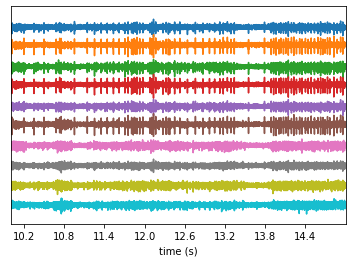

In [33]:
sw.plot_timeseries(ap_extractor, channel_ids=range(40, 50), trange=[10,15])

###### filtered

In [34]:
# ap_extractor_filt = st.preprocessing.bandpass_filter(ap_extractor, freq_max=10000)
# sw.plot_timeseries(ap_extractor_filt, channel_ids=range(40, 50), trange=[10,15])

###### cmr

In [35]:
# ap_extractor_cmr = st.preprocessing.common_reference(ap_extractor)
# sw.plot_timeseries(ap_extractor_cmr, channel_ids=range(45, 55), trange=[10,15])

In [36]:
exp_struct['folders']

{'bird': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/0610_g0',
 'raw': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/0610_g0',
 'sglx': '/mnt/sphere/speech_bci/raw_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'kwik': '/experiment/s_b1253_21/sglx/kwik/2021-07-18/0610_g0',
 'processed': '/mnt/sphere/speech_bci/processed_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'derived': '/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0',
 'tmp': '/experiment/tmp/tmp/0610_g0',
 'msort': '/experiment/tmp/s_b1253_21/sglx/msort/2021-07-18/0610_g0',
 'ksort': '/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0'}

In [37]:
def run_spikesort(recording_extractor: se.RecordingExtractor, 
                  logger: logging.Logger,
                  sort_pickle_path: str,
                  tmp_dir: str, 
                  grouping_property: str=None,
                 sorting_method: str='kilosort3',
                 n_jobs_bin: int=N_JOBS_MAX,
                 chunk_mb: int=512, restrict_to_gpu=None,
                 **sort_kwargs):

    logger.info("Grouping property: {}".format(grouping_property))
    logger.info("sorting method: {}".format(sorting_method))
    
    # try:
    if sorting_method == "kilosort2":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks2')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)

            
        sort = ss.run_kilosort2(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            n_jobs_bin=n_jobs_bin,
            **sort_kwargs
        )
    
    elif sorting_method == "kilosort3":
        # perform kilosort sorting
        sort_tmp_dir = os.path.join(tmp_dir, 'tmp_ks3')
        logger.info('Sorting tmp dir {}'.format(sort_tmp_dir))
        
        if restrict_to_gpu is not None:
            logger.info('Will set visible gpu devices {}'.format(restrict_to_gpu))
            os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
            os.environ["CUDA_VISIBLE_DEVICES"] = "{}".format(restrict_to_gpu)
            
        sort = ss.run_kilosort3(
            recording_extractor,
            car=True,
            output_folder=sort_tmp_dir,
            parallel=True,
            verbose=True,
            grouping_property=grouping_property,
            chunk_mb=chunk_mb,
            **sort_kwargs
        )
        
    else:
        raise NotImplementedError('Only know how to sort kilosort2/3 for now, \
                                        will deal with {} later'.format(sorting_method))
        
    logger.info('done sorting')
    
    # save sort
    logger.info("Saving sort {}".format(sort_pickle_path))
    with open(sort_pickle_path, "wb") as output:
        pickle.dump(sort, output, pickle.HIGHEST_PROTOCOL)
    logger.info("Sorting output saved to {}".format(sort_pickle_path))
      
#     # get templates and max channel
#     logger.info("Getting templates")
#     templates = st.postprocessing.get_unit_templates(
#         recording_extractor,
#         sort,
#         max_spikes_per_unit=200,
#         save_as_property=True,
#         verbose=True,
#         n_jobs=n_jobs_bin,
#         grouping_property=grouping_property,
#     )
    
#     logger.info("Getting main channel")
#     max_chan = st.postprocessing.get_unit_max_channels(
#         recording_extractor, 
#         sort, 
#         save_as_property=True, 
#         verbose=True, 
#         n_jobs=n_jobs_bin
#     )   
    
    # save sort again with all that processed data
    sort_temp_pickle_path = sort_pickle_path + '.dump.pkl'
    logger.info("Saving sort {}".format(sort_temp_pickle_path))
    sort.dump_to_pickle(sort_temp_pickle_path)
    
    return sort

In [38]:
ss.__version__

'0.4.4'

In [39]:
# ks_params = {'kilo_version': 2,
#              'use_gpu': 1,
#             'auto_merge': 1,
#             'filt_per_chan': 4,
#             's_f': int(s_f),
#             'spkTh': -4,
#             'minFR': 1/100,
#             }

In [40]:
default_ks3_params = ss.Kilosort3Sorter.default_params()
default_ks3_params

{'detect_threshold': 6,
 'projection_threshold': [9, 9],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.2,
 'minfr_goodchannels': 0.2,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 300,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'keep_good_only': False,
 'chunk_mb': 500}

##### manually enter ksort params

In [42]:
ks_params = {'minFR': 0.01,
             'minfr_goodchannels': 0.01}

tmp_loc = exp_struct['folders']['ksort']
tmp_loc

'/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0'

#### run the spike sort

In [45]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle')

# sort = run_spikesort(ap_extractor, logger, sort_pickle_path, tmp_loc, restrict_to_gpu=1, 
#                      sorting_method='kilosort3', 
#                      **ks_params)

2021-09-25 18:29:17,074 root         INFO     Grouping property: None
2021-09-25 18:29:17,075 root         INFO     sorting method: kilosort3
2021-09-25 18:29:17,077 root         INFO     Sorting tmp dir /experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/tmp_ks3
2021-09-25 18:29:17,077 root         INFO     Will set visible gpu devices 1
Writing to binary .dat file: 100%|##########| 1329/1329 [2:22:45<00:00,  6.44s/it] 


SpikeSortingError: Spike sorting failed: kilosort3 returned a non-zero exit code. You can inspect the runtime trace in the kilosort3.log of the output folder.'

#### load the sort

In [43]:
sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks3.pickle.dump.pkl')
sort_pickle_path

'/experiment/tmp/s_b1253_21/sglx/ksort/2021-07-18/0610_g0/sort_ks3.pickle.dump.pkl'

In [49]:
#sort_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'sort_ks2.pickle.dump.pkl')
#print(sort_pickle_path)
#loaded_sort = se.load_extractor_from_pickle(sort_pickle_path)

In [35]:
### load the sort directly from kilosort npy files
from ceciestunepipe.util.spike import kilosort as ks

In [36]:
reload(ks)
clu_df, spk_df = ks.load_spikes(os.path.join(exp_struct['folders']['ksort'], 'tmp_ks3'))
spk_df.head(1)

,times,clusters
0,102,119


In [37]:
## call the HVC/RA sites
#clu_df.loc[clu_df['main_chan'].isin(hvc_chans), 'nucleus'] = 'hvc'
ra_chans = np.arange(20, 120)
clu_df.loc[clu_df['main_chan'].isin(ra_chans), 'nucleus'] = 'ra'

#complete some redundancy in the spk_df
spk_df['nucelus'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['nucleus'])
spk_df['main_chan'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['main_chan'])
spk_df['kslabel'] = spk_df['clusters'].map(clu_df.set_index('cluster_id')['KSLabel'])

### save to pickle
spike_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'spk_df.pickle')
clu_pickle_path = os.path.join(exp_struct['folders']['ksort'], 'clu_df.pickle')

spk_df.to_pickle(spike_pickle_path, protocol=4)
clu_df.to_pickle(clu_pickle_path, protocol=4)

In [53]:
clu_df.head(1)

,cluster_id,KSLabel,template,max_chans,main_chan,main_7,main_wav_7,nucleus
1,1,good,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[1, 0, 2, 3, 5, 6, 4, 13, 9, 7, 10, 11, 8, 15,...",1,"[0, 1, 2, 3, 4, 5, 6]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....",NaN


In [46]:
clu_df_ra = clu_df[clu_df['nucleus']=='ra']
np.unique(clu_df_ra['cluster_id']).size

384

In [47]:
# count the mua ones
np.unique(clu_df[clu_df['KSLabel']=='mua']['cluster_id']).size

954

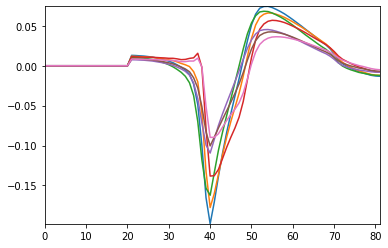

In [38]:
plt.plot(clu_df.loc[40, 'main_wav_7']);

### plot a raster

In [49]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.652952032644,
 's_f_ap_0': 30000.043852965577,
 'start_ms': array([ 6300478,  7102501,  7180616,  7245376,  7661606,  8031581,
         8128521,  8202321,  8442876,  9853004, 11014954, 12578659,
        14212972, 15410472, 15496242, 17104694, 18395779, 20073717,
        20107052, 21557542, 21939152, 23513780, 23676120, 23753090,
        23766770, 24457160, 24816190, 27239488, 27308728, 27405768,
        27495628, 27737218, 28437448, 29355223]),
 'len_ms': array([50765, 38435, 31900, 44620, 55725, 47565, 39805, 34070, 60000,
        45875, 45460, 41365, 39195, 58425, 52140, 46640, 21695, 17460,
        39010, 47655, 52790, 23410, 42345,  9165, 18225, 51855, 57915,
        34420, 42935, 35810, 40380, 51640, 63155, 19065]),
 'start_sample_naive': array([157511950, 177562525, 179515400, 181134400, 191540150, 200789525,
        203213025, 205058025, 211071900, 246325100, 275373850, 314466475,
        355324300, 385261800, 387406050, 427617350, 459894475, 50

### Visualize a bout together with the neural traces

In [39]:
plt.rcParams['lines.linewidth'] = 0.1
from ceciestunepipe.util.sound import spectral as sp
from ceciestunepipe.util import plotutil as pu

In [40]:
axes_pars = {'axes.labelpad': 5,
             'axes.titlepad': 5,
             'axes.titlesize': 'small',
             'axes.grid': False,
             'axes.xmargin': 0,
             'axes.ymargin': 0}

plt.rcParams.update(axes_pars)

In [41]:
from ceciestunepipe.util import wavutil as wu

In [57]:
bout_dict

{'s_f': 25000,
 's_f_nidq': 24999.652952032644,
 's_f_ap_0': 30000.043852965577,
 'start_ms': array([ 6300478,  7102501,  7180616,  7245376,  7661606,  8031581,
         8128521,  8202321,  8442876,  9853004, 11014954, 12578659,
        14212972, 15410472, 15496242, 17104694, 18395779, 20073717,
        20107052, 21557542, 21939152, 23513780, 23676120, 23753090,
        23766770, 24457160, 24816190, 27239488, 27308728, 27405768,
        27495628, 27737218, 28437448, 29355223]),
 'len_ms': array([50765, 38435, 31900, 44620, 55725, 47565, 39805, 34070, 60000,
        45875, 45460, 41365, 39195, 58425, 52140, 46640, 21695, 17460,
        39010, 47655, 52790, 23410, 42345,  9165, 18225, 51855, 57915,
        34420, 42935, 35810, 40380, 51640, 63155, 19065]),
 'start_sample_naive': array([157511950, 177562525, 179515400, 181134400, 191540150, 200789525,
        203213025, 205058025, 211071900, 246325100, 275373850, 314466475,
        355324300, 385261800, 387406050, 427617350, 459894475, 50

In [42]:
s_f_wav, mic_stream = wu.read_wav_chan(exp_struct['files']['wav_mic'])

In [59]:
ap_sf = all_syn_dict['ap_0']['s_f']


### one example of bout onset

In [43]:
#hvc_chans = list(range(290, 324)) #HVC
ra_chans = list(range(50, 101)) #RA

#neur_chans = hvc_chans + ra_chans
neur_chans = ra_chans

mot_idx = 0

mot_start_wav = bout_dict['start_sample_wav'][mot_idx]
mot_start_ap = bout_dict['start_sample_ap_0'][mot_idx]

pre_sec = -2.25
post_sec = 4 - pre_sec

ap_sf = all_syn_dict['ap_0']['s_f']

mic_arr = mic_stream[mot_start_wav + int(pre_sec*s_f_wav): mot_start_wav + int(post_sec*s_f_wav)]

ap_arr_arr = run_recordings['ap_0'].get_traces(channel_ids=neur_chans, 
                                            start_frame=mot_start_ap + int(pre_sec*ap_sf), 
                                            end_frame=mot_start_ap + int((post_sec*ap_sf)))

<ipython-input-63-12a952a9720b>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')
<ipython-input-63-12a952a9720b>:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])


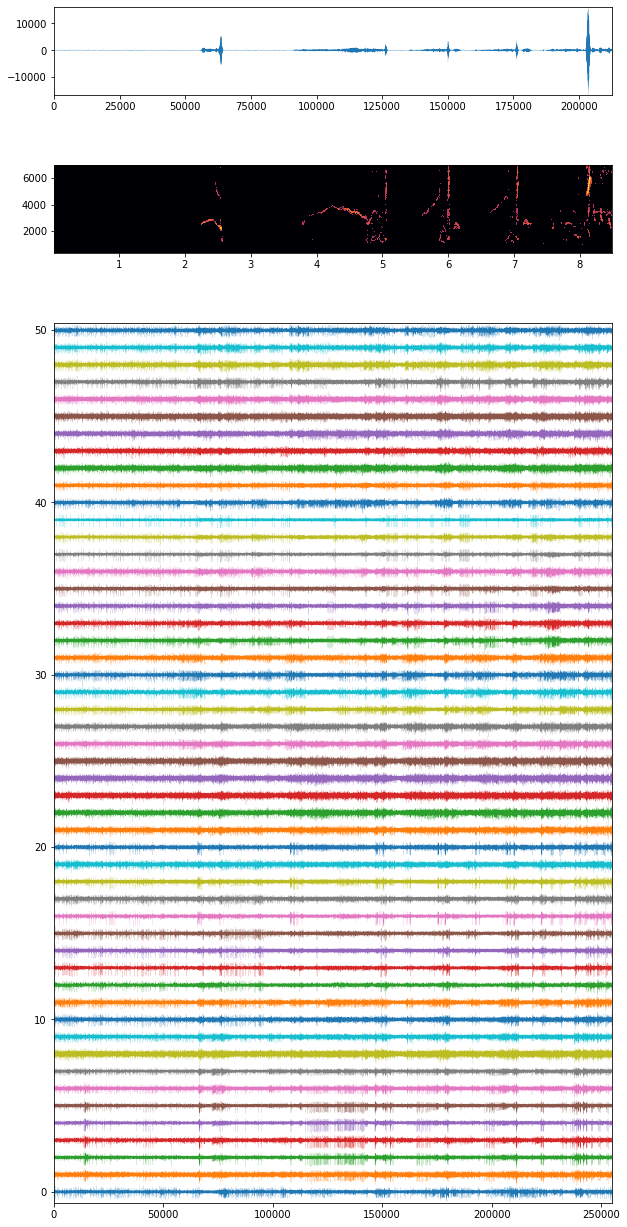

In [63]:
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 1, 10]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), s_f_wav)

ax[0].plot(mic_arr.flatten())

ax[1].pcolormesh(t, f, np.log(sxx), cmap='inferno')

pu.plot_array(ap_arr_arr.T.astype(np.float), ax=ax[2])

### load the spikes

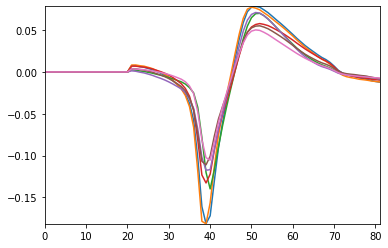

In [50]:
plt.plot(clu_df.loc[12, 'main_wav_7']);

#### check alignment of the syn signals

In [128]:
## have to do it, but it won't be like this
# n_samples_ap = run_recordings['ap_0'].get_traces().shape[-1]
# ap_syn = rsgl.ExtractDigital(run_recordings['ap_0']._raw, 0, n_samples_ap, 0, [0], run_recordings['ap_0']._meta)

# n_samples_nidq = run_recordings['nidq'].get_traces().shape[-1]
# nidq_syn= rsgl.ExtractDigital(run_recordings['nidq']._raw, 0, n_samples_nidq, 0, [0], run_recordings['nidq']._meta).flatten()

2021-06-17 16:05:20,683 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Extracting digital on imec stream: there is only one channel, if any (SYN) and will be converted from an int16 channel 
2021-06-17 16:05:20,685 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     allocated array for syn channel of size (617560864,)
2021-06-17 16:13:14,516 ceciestunepipe.util.spikeextractors.extractors.readSGLX INFO     Threshold for logical hi is 32.00164912004527


#### plot together the syn signals of the ap, nidq channels, the mic raw trace for all the motifs

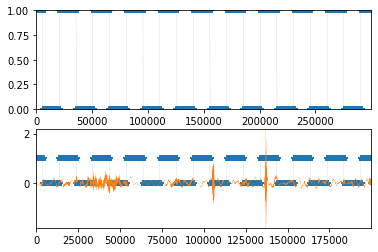

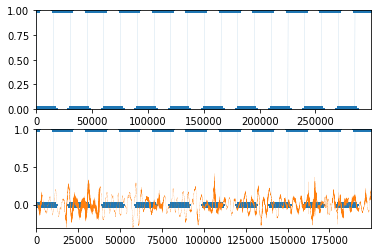

In [129]:
# mot_idx = 8
# sec_before = 0
# sec_after = 10

# for mot_idx in range(2):
#     start_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_before)
#     end_ap = bout_dict['start_sample_ap_0'][mot_idx] + int(run_recordings['ap_0']._s_f_0 * sec_after)

#     start_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_before)
#     end_nidq = bout_dict['start_sample_nidq'][mot_idx] + int(run_recordings['nidq']._s_f_0 * sec_after)

#     fig, ax = plt.subplots(nrows=2)
#     ax[0].plot(ap_syn[start_ap: end_ap], '-*')
#     ax[1].plot(nidq_syn[start_nidq: end_nidq], '-*')
#     ax[1].plot(mic_stream[0, start_nidq: end_nidq]/15000)

In [44]:
## get the actural raster for some clusters
def get_window_spikes(spk_df, clu_list, start_sample, end_sample):
    onset = start_sample
    offset = end_sample
    
    spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]
    
    spk_arr = np.zeros((clu_list.size, offset - onset))

    for i, clu_id in enumerate(clu_list):
        clu_spk_t = spk_t.loc[spk_t['clusters']==clu_id, 'times'].values
        spk_arr[i, clu_spk_t - onset] = 1
    return spk_arr
    
def get_rasters(spk_df, clu_list, start_samp_arr, span_samples):
    # returns np.array([n_clu, n_sample, n_trial])
    
    # get the window spikes for all of the clusters, for each of the start_samp_arr
    spk_arr_list = [get_window_spikes(spk_df, clu_list, x, x+span_samples) for x in start_samp_arr]
    return np.stack(spk_arr_list, axis=-1)


def collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream):
    s_f_ap = run_recordings['ap_0']._s_f_0
    s_f_nidq = run_recordings['nidq']._s_f_0
    
    ## add the length of the bout (in seconds) to the end of the segment
    t_post += int(bout_dict['len_ms'][bout_idx] * 0.001)
       
    start_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f']* t_pre)
    end_ap = bout_dict['start_sample_ap_0'][bout_idx] + int(all_syn_dict['ap_0']['s_f'] * t_post)

    start_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_pre)
    end_wav = bout_dict['start_sample_wav'][bout_idx] + int(all_syn_dict['wav']['s_f'] * t_post)


    # get the streams/spike array
    spk_arr = get_window_spikes(spk_df, clu_list, int(start_ap), int(end_ap))
    mic_arr = mic_stream.flatten()[start_wav: end_wav]
    
    return spk_arr, mic_arr
    
#clu_list = np.array([5, 6])
#clu_list = np.unique(clu_df.loc[clu_df['KSLabel']=='good', 'cluster_id'])
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


bout_idx = 0
spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream)


#rast_arr = get_rasters(spk_df, clu_list, mot_dict['start_sample_ap_0'] + t_pre_samp, t_post_samp - t_pre_samp)

<ipython-input-44-20da126b4dfe>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


In [45]:
clu_list.size

62

<ipython-input-60-20da126b4dfe>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


NameError: name 'sp' is not defined

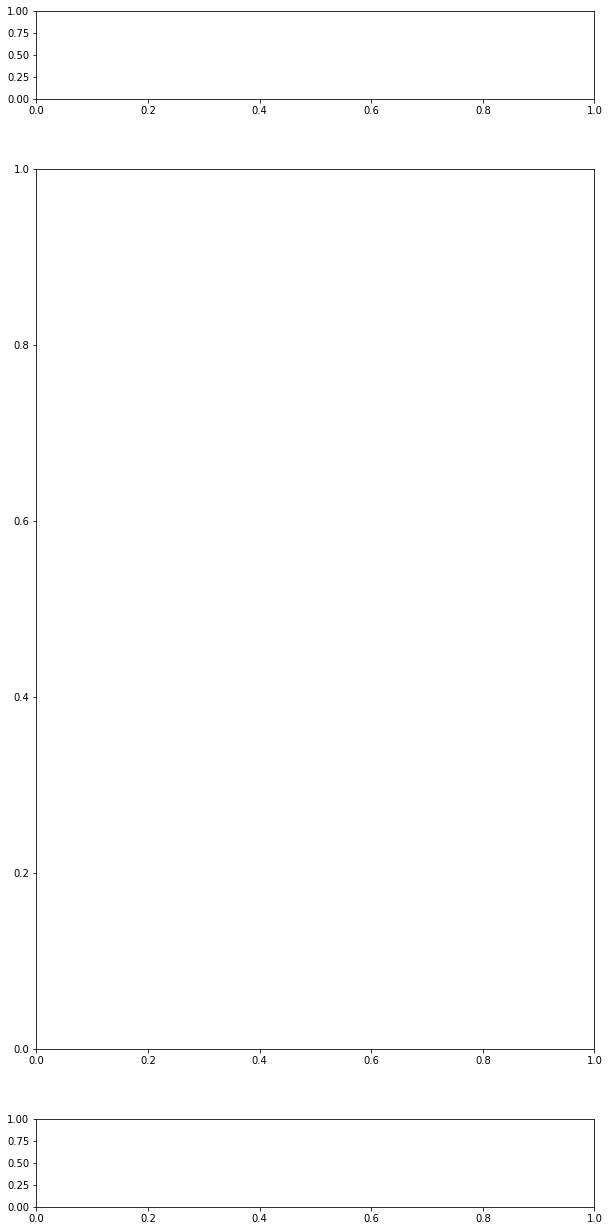

In [61]:
def plot_as_raster(x, ax=None, t_0=None):
    #x is [n_events, n_timestamps] array
    n_y, n_t = x.shape
    
    row = np.ones(n_t) + 1
    t = np.arange(n_t)
    col = np.arange(n_y)
    
    frame = col[:, np.newaxis] + row[np.newaxis, :]
    x[x==0] = np.nan
    
    if ax is None:
        fig, ax = plt.subplots()
    
    raster = ax.scatter(t * x, frame * x, marker='.', facecolor='k', s=1, rasterized=False)
    if t_0 is not None:
        ax.axvline(x=t_0, color='red')
    return ax


#### what to plot
# pick units
clu_list = np.unique(clu_df.loc[(clu_df['KSLabel']=='good') & (clu_df['nucleus'].isin(['hvc', 'ra'])), 
                                'cluster_id'])

#pick window around a bout
t_pre = - 15
t_post = 15

s_f_ap = all_syn_dict['ap_0']['s_f']
t_pre_samp = int(t_pre * s_f_ap)
t_post_samp = int(t_post * s_f_ap)


##Pick a bout
bout_idx = 2

# get the streams/spike array
spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream)


# plot
fig, ax = plt.subplots(nrows=3, gridspec_kw={'height_ratios': [1, 10, 1]}, figsize=(10, 22))

f, t, sxx = sp.ms_spectrogram(mic_arr.flatten(), all_syn_dict['wav']['s_f'])

#ax[0].plot(mic_arr.flatten())

ax[0].pcolormesh(t, f, np.log(sxx), cmap='inferno')

plot_as_raster(spk_arr, t_0=int(-pre_sec*s_f_ap), ax=ax[1])

bin_size_ms = 10
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'])
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

ax[2].plot(psth);

plt.tight_layout()

In [46]:
from ceciestunepipe.util import plotutil as pu

In [ ]:
bin_size_sample

/home/finch/repos/ceciestunepipe/ceciestunepipe/util/plotutil.py:66: RuntimeWarning: Mean of empty slice
  coarse_x = np.nanmean(exploded_x, axis=-1)


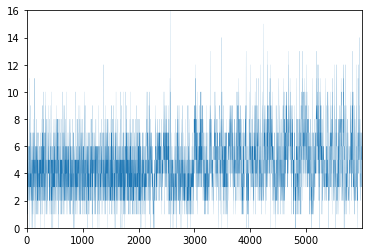

In [71]:
# plot a 'psth' of the summed activity of all units
bin_size_ms = 5
bin_size_sample = int(bin_size_ms * 0.001 *  all_syn_dict['ap_0']['s_f'] )
psth = np.nansum(pu.coarse(spk_arr, bin_size_sample), axis=0)

plt.plot(psth);

In [161]:
fig_path = os.path.join(exp_struct['folders']['derived'], 'bout_1_raster_sua')
fig.savefig(fig_path+'.png')
fig.savefig(fig_path+'.eps')

### save cluster, motif and cluster metadata

In [64]:
import pickle

In [ ]:
clu_df_path = os.path.join(exp_struct['folders']['derived'], 'clu_df.pkl')
clu_df.to_pickle(clu_df_path)

spk_df_path = os.path.join(exp_struct['folders']['derived'], 'spk_df.pkl')
spk_df.to_pickle(spk_df_path)

mot_dict_path = os.path.join(exp_struct['folders']['derived'], 'mot_dict.pkl')
with open(mot_dict_path, 'wb') as handle:
    pickle.dump(bout_dict, handle)


In [ ]:
exp_struct['folders']['processed']

In [48]:
bin_spk_arr.shape

NameError: name 'bin_spk_arr' is not defined

### Collect all bouts for all clusters and make a dataframe

In [47]:
clu_list = np.unique(clu_df['cluster_id'])
clu_list.shape

(1205,)

In [48]:
spk_arr_list = []
mic_arr_list = []
clu_id_arr_list = []

t_pre = 5
t_post = 5

## get the bouts arrays
for bout_idx, start in enumerate(bout_dict['start_ms']):
    spk_arr, mic_arr = collect_bout(bout_dict, bout_idx, run_recordings, t_pre, t_post, spk_df, clu_list, mic_stream)
    spk_arr_list.append(spk_arr)
    mic_arr_list.append(mic_arr)
    clu_id_arr_list.append(np.array(clu_list))
    

## make into a pandas dataframe
bout_dict['spk_arr'] = spk_arr_list
bout_dict['mic_arr'] = mic_arr_list
bout_dict['clu_id_arr'] = clu_id_arr_list
keys_to_df = ['start_sample_nidq', 'start_sample_ap_0', 'len_ms', 'spk_arr', 'mic_arr', 'clu_id_arr']

bout_dict_df = {k: bout_dict[k] for k in keys_to_df}
bout_df = pd.DataFrame.from_dict(bout_dict_df)

bout_df.head()

<ipython-input-44-20da126b4dfe>:6: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  spk_t = spk_df.loc[spk_df['times'].between(onset, offset, inclusive=False)]


,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr
0,157509764,189017379,50765,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[270, 294, 204, 8, -196, -330, -363, -260, -50...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,177560061,213078440,38435,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 62, 82, 64, 17, -10, -18, 4, 35, 69, 74, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,179512908,215421889,31900,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-65, -48, -29, -25, -1, -23, -37, -29, -30, -...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,181131886,217364725,44620,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[387, -315, -92, 362, 54, -385, 63, 423, -111,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
4,191537492,229851811,55725,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[198, 217, 215, 177, 79, -28, -166, -283, -343...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [49]:
bout_df['is_sua'] = [np.array(clu_df['KSLabel']=='good') for i in range(bout_df.index.size)]
bout_df['is_ra'] = [np.array(clu_df['nucleus']=='ra') for i in range(bout_df.index.size)]
bout_df['is_mua'] = [np.array(clu_df['KSLabel']=='mua') for i in range(bout_df.index.size)]
bout_df.head()

,start_sample_nidq,start_sample_ap_0,len_ms,spk_arr,mic_arr,clu_id_arr,is_sua,is_ra,is_mua
0,157509764,189017379,50765,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[270, 294, 204, 8, -196, -330, -363, -260, -50...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, True, True...","[False, False, False, False, False, False, Fal..."
1,177560061,213078440,38435,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[17, 62, 82, 64, 17, -10, -18, 4, 35, 69, 74, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, True, True...","[False, False, False, False, False, False, Fal..."
2,179512908,215421889,31900,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[-65, -48, -29, -25, -1, -23, -37, -29, -30, -...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, True, True...","[False, False, False, False, False, False, Fal..."
3,181131886,217364725,44620,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[387, -315, -92, 362, 54, -385, 63, 423, -111,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, True, True...","[False, False, False, False, False, False, Fal..."
4,191537492,229851811,55725,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[198, 217, 215, 177, 79, -28, -166, -283, -343...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[True, True, True, True, True, True, True, Tru...","[False, False, False, False, False, True, True...","[False, False, False, False, False, False, Fal..."


### Save it

In [50]:
bout_df_path = os.path.join(exp_struct['folders']['derived'], 'bout_df_allunits.pkl')
logger.info('saving the bout dataframe to {}'.format(bout_df_path).format(bout_df_path))
bout_df.to_pickle(bout_df_path)
logger.info('saved')

2021-10-06 23:06:23,876 root         INFO     saving the bout dataframe to /mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/bout_df_allunits.pkl
2021-10-07 00:04:15,786 root         INFO     saved


In [51]:
bout_df_path

'/mnt/sphere/speech_bci/derived_data/s_b1253_21/2021-07-18/sglx/0610_g0/bout_df_allunits.pkl'